In [244]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
sns.set_style('darkgrid')
matplotlib.rc('font', size=10)
matplotlib.rc('axes', titlesize=10)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('figure', titlesize=10)
%matplotlib inline

In [249]:
train = pd.read_excel("train.xlsx")

## Data Preprocessing

#### Adjusting salary for skewness

-0.09825249198384019

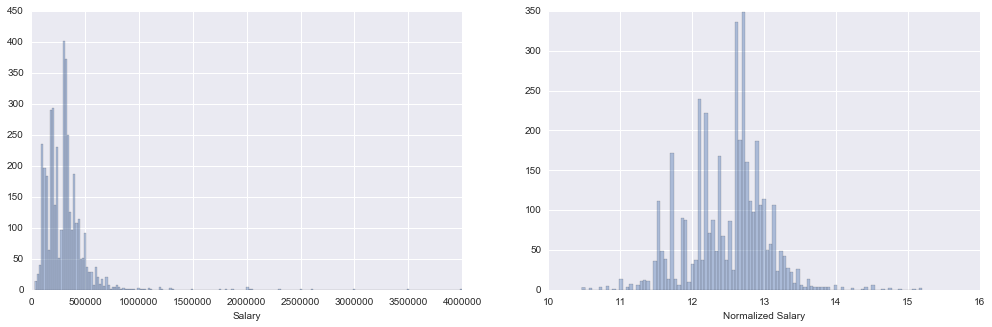

In [250]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train['Salary'], kde = False, ax = ax1, bins = 200)
sns.distplot(np.log1p(train["Salary"]), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)
train['Salary'] = np.log1p(train["Salary"])
skew(train.Salary)

In [192]:
def convertTF(df,featureList):
    d = {True:1, False:0}
    for feature in featureList:
        df[feature] = df[feature].apply(lambda x: d[x])
    return df

def yearReturn(x):
    return x.year

def pos(x):
    if x > 0: 
        return 1
    else:
        return 0
def neg(x):
    if x < 0:
        return 1
    else:
        return 0

def val(x):
    if x > 0.44:
        return 3
    elif x < -0.44:
        return 1
    else:
        return 2

def conv_english(x) :
    if x >= 520:
        return 3
    elif x < 420:
        return 1
    else:
        return 2

def conv_logical(x) :
    if x >= 600:
        return 3
    elif x < 450:
        return 1
    else:
        return 2
    
def conv_quant(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def conv_prog(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def gpaCal(x):
    if x <= 10:
        return x*10
    else:
        return x
    
def isNationalBoard(row):
    if (row['isCbse'] or row['isISC'] or row['isICSE']):
        return 1
    else:
        return 0

def prepare(train):
    # Extract Designation
    train['isSenior'] = train.Designation.str.contains('senior')
    train['isSoftware'] = train.Designation.str.contains('software')
    train['isManager'] = train.Designation.str.contains('manager')
    train['isEngineer'] = train.Designation.str.contains('engineer')
    train['isDeveloper'] = train.Designation.str.contains('developer')
    
    # Extract Degree
    train['isBtech'] = train.Degree.str.contains('B.Tech/B.E.')
    train['isMCA'] = train.Degree.str.contains('MCA')
    train['isMtech'] = train.Degree.str.contains('M.Tech./M.E.')
    
    # Extract Board of Examination
    train['isCbse'] = train['12board'].str.contains('cbse')
    train['isStateBoard'] = train['12board'].str.contains('state board')
    train['isISC'] = train['12board'].str.contains('isc')
    train['isICSE'] = train['12board'].str.contains('icse')
    train['isCbse'].fillna(value = False, inplace = True)
    train['isStateBoard'].fillna(value = False, inplace = True)
    train['isISC'].fillna(value = False, inplace = True)
    train['isICSE'].fillna(value = False, inplace = True)
    train['isNationalBoard'] = 0
    train['isNationalBoard'] = train.apply(lambda x : isNationalBoard(x), axis=1)
    
    
    # Extract Specialization
    train['isCSE'] = train.Specialization.str.contains('computer engineering')
    train['isECE'] = train.Specialization.str.contains('electronics and communication engineering')
    train['isIT'] = train.Specialization.str.contains('information technology')
    train['isMech'] = train.Specialization.str.contains('mechanical engineering')
    train['isICE'] = train.Specialization.str.contains('instrumentation and control engineering')
    train['isEE'] = train.Specialization.str.contains('electrical engineering')
    
    train = convertTF(train, ['isCbse', 'isStateBoard', 'isISC', 'isICSE', 'isBtech', 'isMCA', 'isMtech', 'isSenior', 'isSoftware', 'isManager', 'isEngineer', 'isDeveloper','isCSE', 'isECE', 'isIT', 'isMech', 'isICE', 'isEE'])
    
    # Cleaning
    m = train.ComputerProgramming.mean(skipna=True)
    train.ComputerProgramming.fillna(m, inplace=True)

    n = train.Domain.mean(skipna=True)
    train.Domain.fillna(n, inplace=True)

    train.GraduationYear.replace(0,None,inplace=True)
    m = train.GraduationYear.mean(skipna=True)
    train.GraduationYear.fillna(m, inplace=True)
    
    # Generate Features

    #MaxDomain : max of the domains in one column
    train['maxDomain'] = train[['ComputerProgramming','ComputerScience','ElectronicsAndSemicon','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']].max(axis=1)

    # diffGrad : difference between Graduation Year & 12th graduation, to see whether drop in college affect scores
    train['diffGrad'] = train.GraduationYear - train['12graduation']

    # diffGradDOB : difference between Graduation Year and DOB
    train['DOBY'] = train.DOB.apply(yearReturn)
    train['diffGradDOB'] = train.GraduationYear - train.DOBY
    
    # Big Five scores
    train['bigfive'] = 0
    train.bigfive += train.agreeableness.apply(lambda x : val(x))
    train.bigfive += train.conscientiousness.apply(lambda x : val(x))
    train.bigfive += train.nueroticism.apply(lambda x : val(x))
    train.bigfive += train.extraversion.apply(lambda x : val(x))
    train.bigfive += train.openess_to_experience.apply(lambda x : val(x))
    
    # Translate English / Logical / Quants scores
    train['scores'] = 0
    train['scores'] += train.English.apply(lambda x : conv_english(x))
    train['scores'] += train.Logical.apply(lambda x : conv_logical(x))
    train['scores'] += train.Quant.apply(lambda x : conv_quant(x))
    train['scores'] += train.ComputerProgramming.apply(lambda x : conv_prog(x))
    
    # Fix GPA to 100 scale
    train['mcolgGPA'] = train.collegeGPA.apply(lambda x: gpaCal(x))
    
    #Feature columns to take
    feature_cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']
    X = train[feature_cols]
    y = train.Salary
    
    return X,y

In [193]:
X, Y = prepare(train)

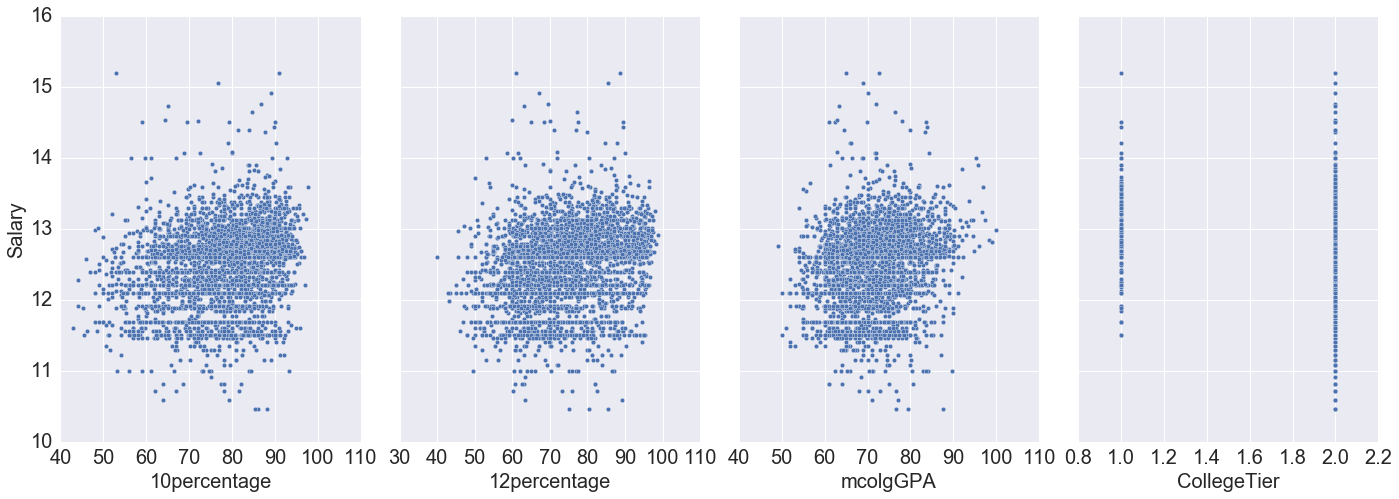

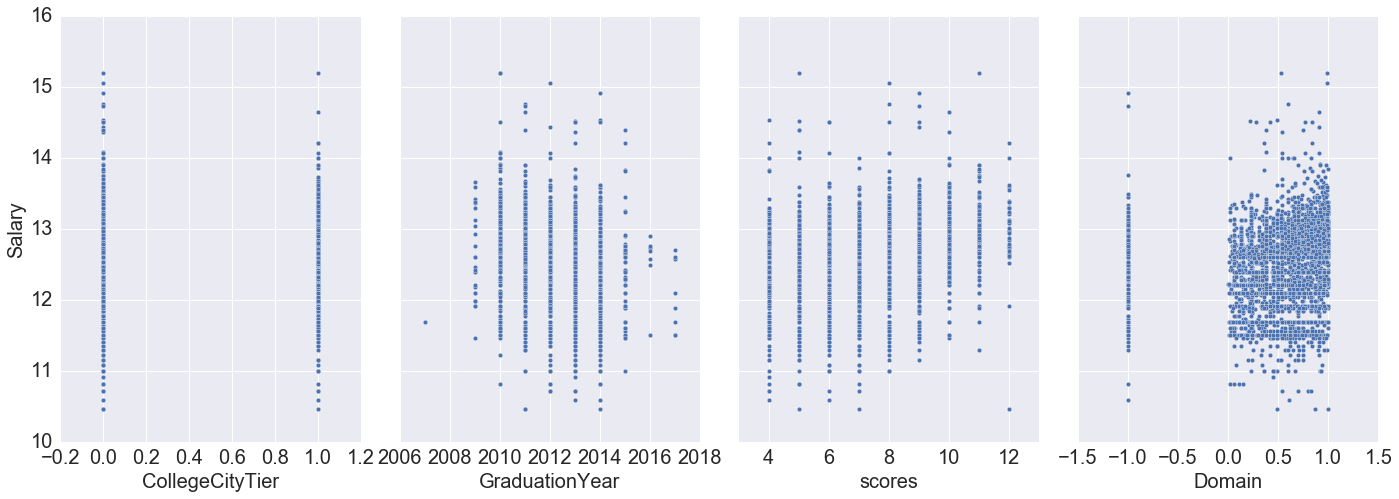

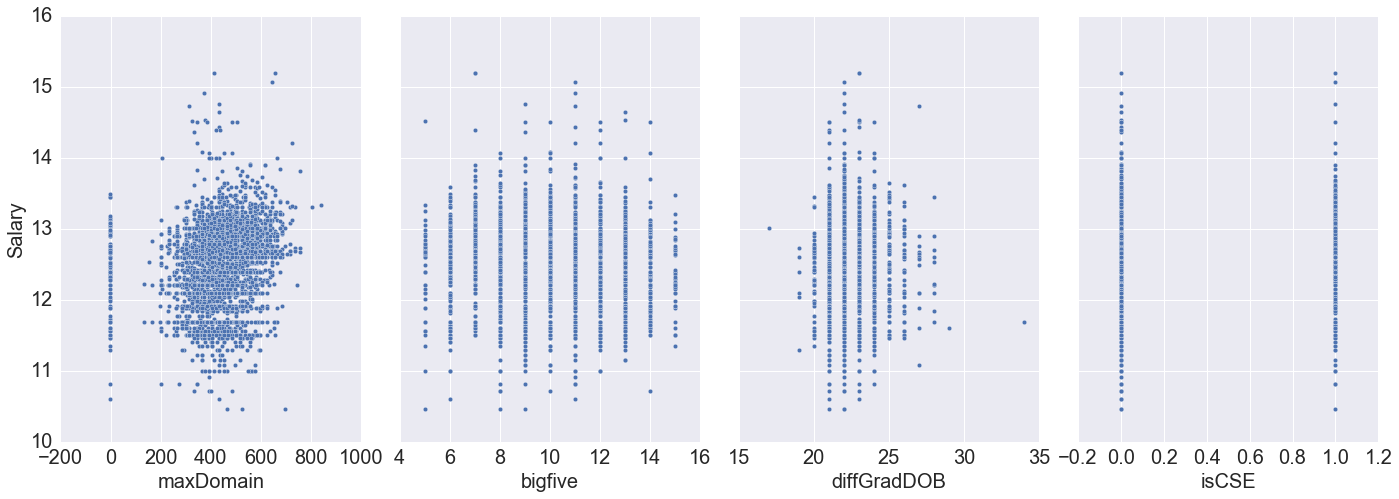

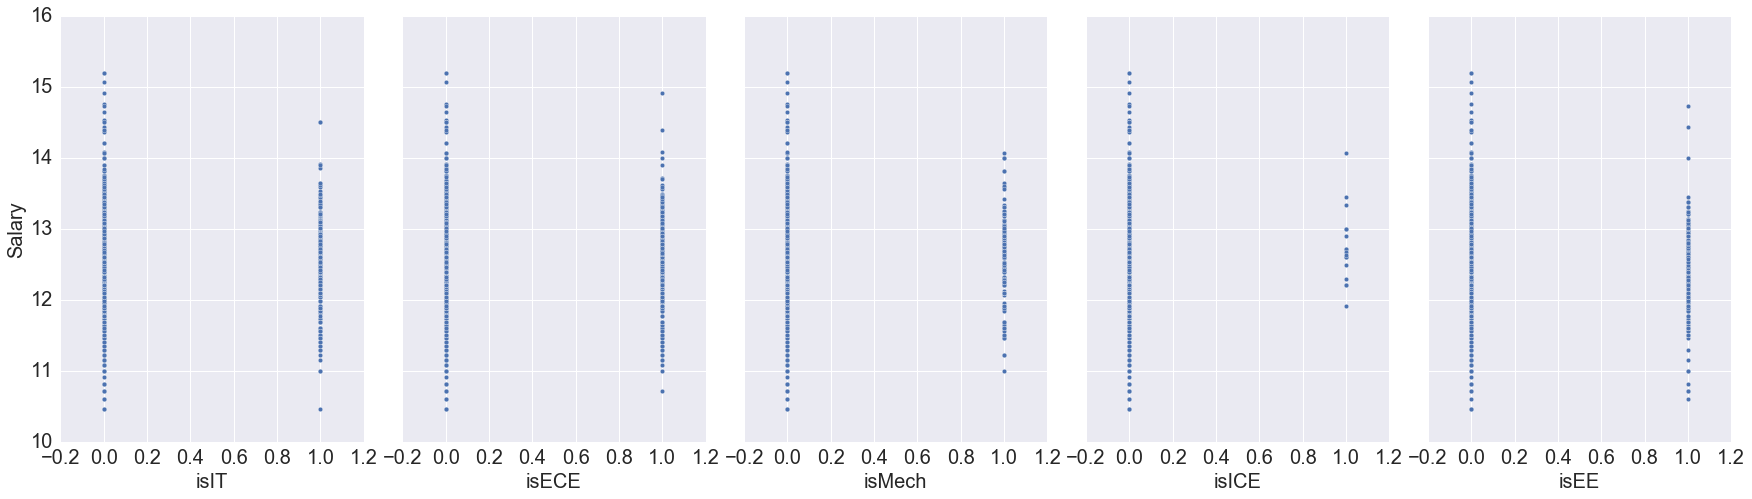

In [194]:
cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']

sns.pairplot(train, x_vars = cols[:4], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[4:8], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[8:12], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[12:], y_vars = 'Salary', size = 7, aspect = 0.7)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2 ,random_state = 1)
X_train.head()

,10percentage,12percentage,mcolgGPA,CollegeTier,CollegeCityTier,GraduationYear,scores,Domain,maxDomain,bigfive,diffGradDOB,isCSE,isIT,isECE,isMech,isICE,isEE
train,58.80,65.5,51.00,2,1,2011,6,0.538387,333,10,24,0,0,0,0,0,0
train,86.00,85.8,72.14,2,1,2013,8,0.058793,475,11,23,0,0,1,0,0,0
train,87.83,94.0,78.18,2,1,2013,7,-1.000000,355,12,21,0,0,0,0,0,1
train,84.20,87.4,77.00,2,0,2010,4,0.229482,445,12,21,0,0,0,0,0,1
train,86.50,87.5,68.00,2,0,2012,4,0.824666,420,11,22,0,0,1,0,0,0


### Computing Skewness

(Result: Within Acceptable Limits)

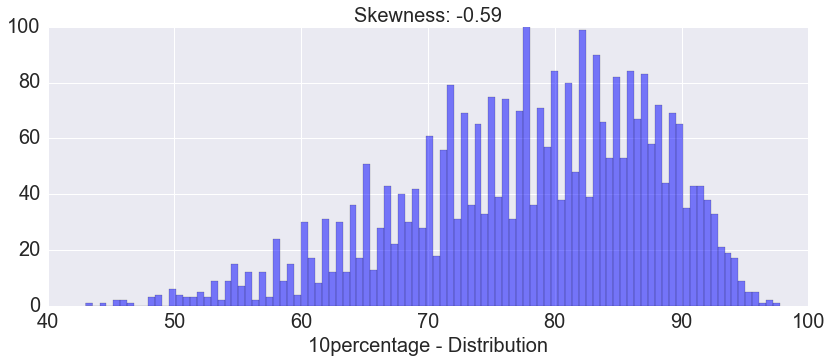

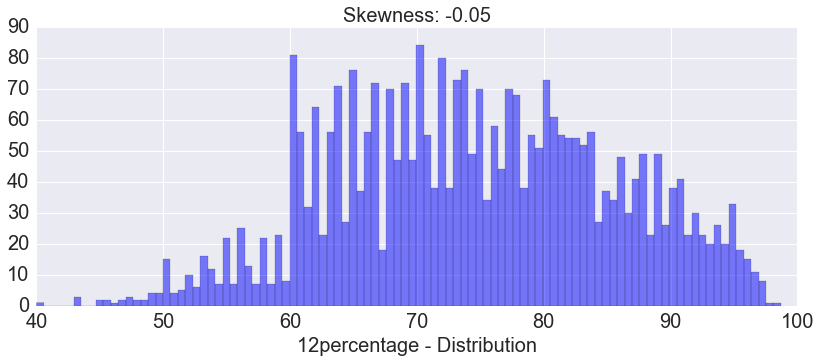

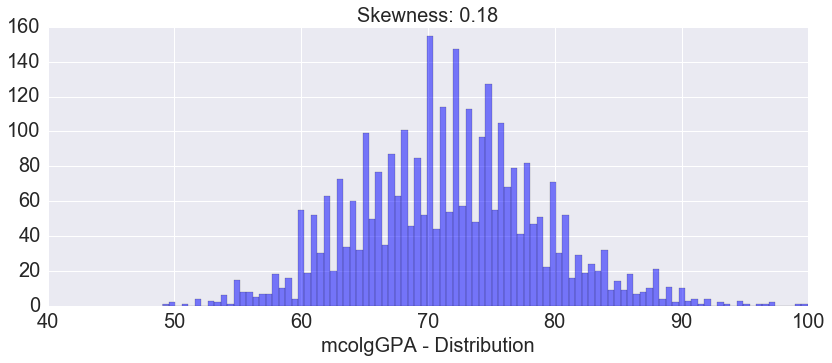

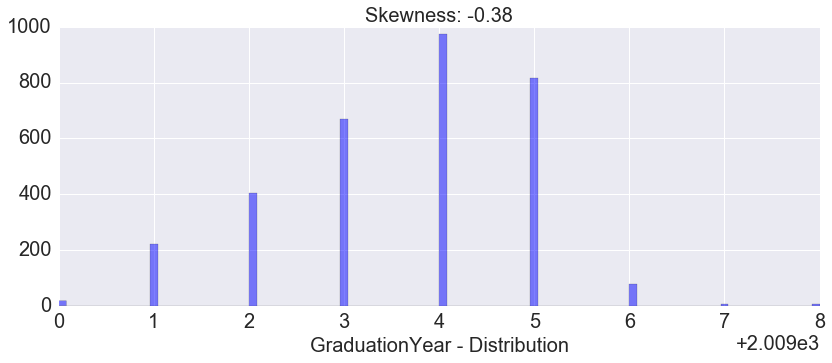

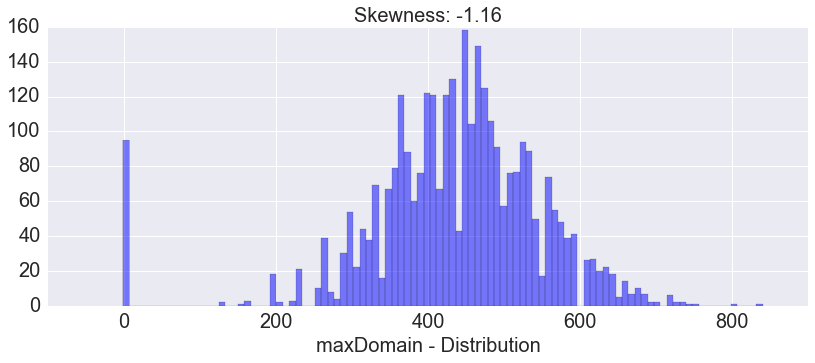

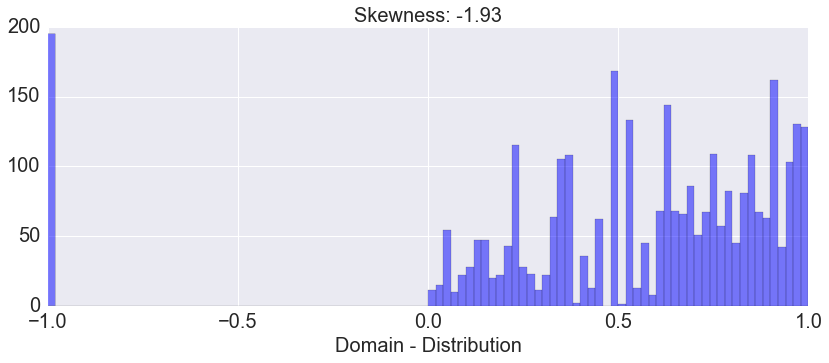

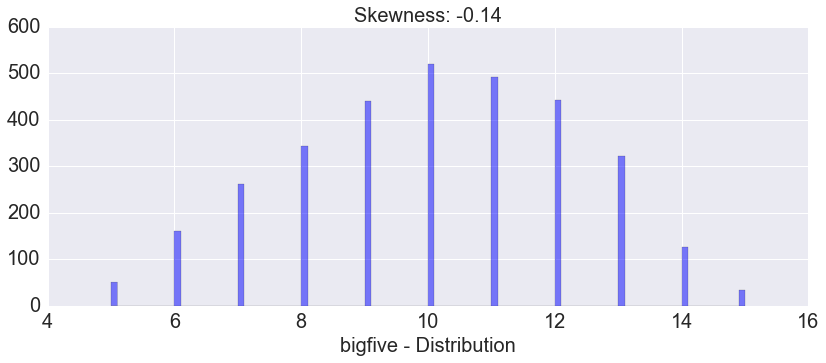

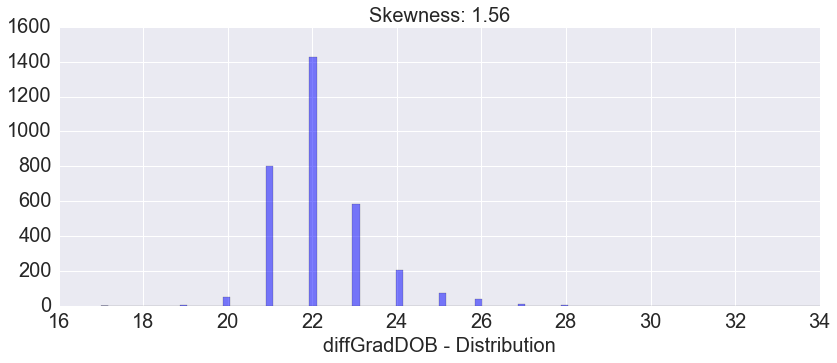

In [196]:
classes = ['10percentage', '12percentage', 'mcolgGPA', 'GraduationYear', 'maxDomain', 'Domain', 'bigfive', 'diffGradDOB']
X_u = pd.DataFrame()
for c in classes:
    param = X_train[c] 
    skness = skew(param) 
    figure = plt.figure(figsize=(30,5))
    figure.add_subplot(121)   
    plt.hist(param,facecolor='blue',alpha=0.5, bins=100) 
    plt.xlabel(c + " - Distribution") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    plt.show()

In [197]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="mean_squared_error", cv = 5))
    return(cve)

SVM Regression
MAE : 0.424635
RMSE : 0.549110




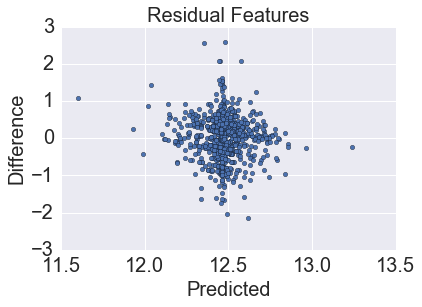

Random Forests
MAE : 0.360865
RMSE : 0.493487




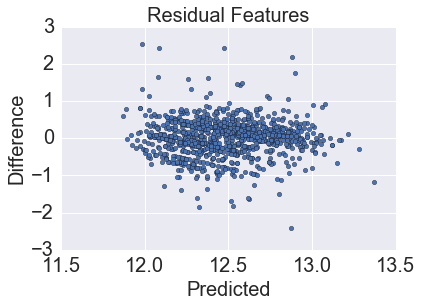

Ridge Regression
MAE : 0.359375
RMSE : 0.488849




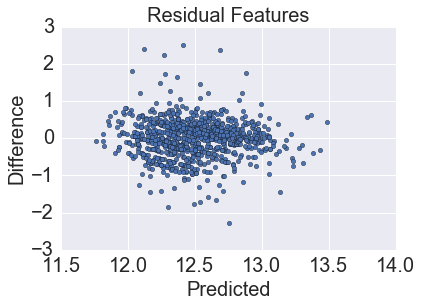

Lasso Regression
MAE : 0.359208
RMSE : 0.489167




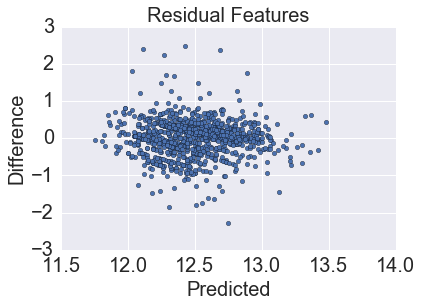

MLP (NN)
MAE : 0.389664
RMSE : 0.525992




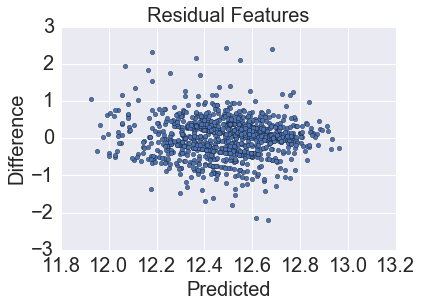

In [211]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("\n")

def model_train(model,X,y):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    #SVM Regression
    svm_clf = svm.SVR()
    print ("SVM Regression")
    model_train(svm_clf, X, y)
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 1500,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)
    
    #Linear SVM Regression
    ridge_clf = Ridge(alpha=0.1)
    print ("Ridge Regression")
    model_train(ridge_clf, X, y)
    
    #Lasso Regression
    lasso_clf = linear_model.Lasso(alpha=0.001, selection="random", random_state=1)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #Linear Regression
    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
    print ("MLP (NN)")
    model_train(mlp_clf, X, y)

    
    return svm_clf, rand_clf, ridge_clf, lasso_clf, mlp_clf

svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf = training(X, Y)


In [217]:
lasso_clf = linear_model.Lasso(alpha=0.001, selection="random", random_state=1)
lasso_clf.fit(X,Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='random', tol=0.0001, warm_start=False)

In [219]:
print(test.shape)

(1500, 38)


In [243]:
test  = pd.read_excel('test.xlsx', na_values=-1)
X, y = prepare(test)
def testing(X, model, ds, file_name):
    y_pred = np.expm1(model.predict(X))
    submission = pd.DataFrame(columns=['ID','Salary'])
    submission.ID = ds.ID
    submission.Salary = y_pred
    writer_orig = pd.ExcelWriter(file_name, engine='xlsxwriter')
    submission.to_excel(writer_orig, index=False, sheet_name='report')
    writer_orig.save()
testing(X, lasso_clf, test, 'result.xlsx')

In [246]:
y  = pd.read_excel('result.xlsx', na_values=-1)

In [247]:
y.mean()

ID        665286.300667
Salary    276472.889004
dtype: float64

(array([  1.,   0.,   1.,   2.,   3.,   4.,   7.,   8.,   6.,   7.,   7.,
          9.,   7.,  11.,   9.,  11.,  13.,  12.,  25.,  14.,  22.,  21.,
         17.,  22.,  20.,  18.,  17.,  30.,  24.,  20.,  27.,  22.,  22.,
         24.,  21.,  23.,  28.,  23.,  30.,  27.,  18.,  34.,  16.,  28.,
         26.,  19.,  30.,  24.,  27.,  24.,  22.,  18.,  29.,  21.,  22.,
         24.,  16.,  29.,  22.,  11.,  18.,  12.,  20.,  15.,  13.,  12.,
         11.,   7.,  14.,  14.,   9.,  10.,   8.,   9.,  14.,   6.,   6.,
          8.,  12.,  11.,   7.,   9.,  12.,   9.,  14.,   4.,   4.,  13.,
          8.,   6.,   2.,   5.,   3.,   4.,   7.,   2.,   4.,   7.,   4.,
          4.,   2.,   3.,   3.,   3.,   2.,   2.,   4.,   3.,   0.,   3.,
          2.,   1.,   1.,   0.,   1.,   2.,   4.,   1.,   0.,   1.,   3.,
          2.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   3.,   1.,   1.,
          2.,   1.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

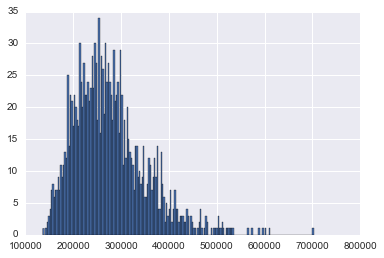

In [248]:
plt.hist(y.Salary, bins=200)